In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from strategies_and_optimisation import gen_daily_sharpe, custom_grid_search, momentum_strat, mean_reversion, post_div_drift, SMAC, EMAC

In [3]:
# Import and organise dataframe
df = pd.read_csv('Q32019_Q22020.csv')
df['Date'] = pd.to_datetime(df['Date'])

start_date = df['Date'].min()
end_date = df['Date'].max()

df.set_index(['Date', 'PlayerName'], inplace=True)
df.sort_index(level=0, inplace=True)

df['daily_log_returns'] = df['EndofDayPrice'].apply(np.log).groupby(level=1).diff(1)
df['daily_mkt_log_returns'] = df['ave_mkt_price'].apply(np.log).groupby(level=1).diff(1) 

first_day = df.loc[(start_date, slice(None)), :]
top200_mask = first_day.nlargest(200, 'EndofDayPrice').index.droplevel(0).values
top200 = df.loc[(slice(None), top200_mask), :]

In [36]:
# Set plot style
style.use('fivethirtyeight')

# Initial exploratory plots. 
We will consider FIE top200 index against the SP500 (SPY). Lack of market beta is really sick.

TODO: COMBINE THE PLOTS and beautify

Text(0.5, 1.0, 'Cumulative index returns')

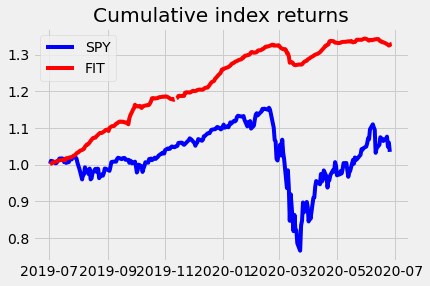

In [67]:
# Comparing to SP500
SPY = yf.Ticker('SPY')
#SPY_history = SPY.history(start=start_date, end=end_date)['Close'] # Care dont overuse, works on yahoo scraping.
SPY_log_returns = SPY_history.apply(np.log).diff(1)
SPY_cum_returns = SPY_log_returns.cumsum().apply(np.exp)

# Extract index price
index_price = df.groupby(level=0)['ave_mkt_price'].head(1).values
# Football index tracker fund (FIT) (comprising of top200)
FIT_log_returns = df['daily_mkt_log_returns'].groupby(level=0).head(1).droplevel(1)
FIT_cum_returns = FIT_log_returns.cumsum().apply(np.exp)

# Plot cumulative returns
fig, ax = plt.subplots()
ax.plot(SPY_cum_returns.index, SPY_cum_returns, color='b', label='SPY')
ax.plot(FIT_cum_returns.index, FIT_cum_returns, color='r', label='FIT')
ax.legend()
ax.set_title('Cumulative index returns')

Now consider Sharpe ratios for the 2 instruments...

SPY annualised Sharpe ratio: 0.017053480482439574
FIT annualised Sharpe ratio: 0.38883467275258227


Text(0.5, 1.0, 'Daily index returns')

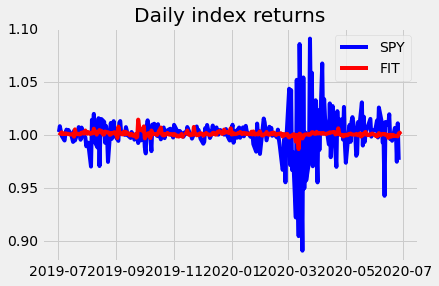

In [68]:
# Benchmark Sharpe ratios

# First generate daily returns
SPY_daily_returns = SPY_log_returns.apply(np.exp)
FIT_daily_returns = FIT_log_returns.apply(np.exp)

SPY_sharpe = gen_daily_sharpe(SPY_daily_returns)
print('SPY annualised Sharpe ratio: ' + str(SPY_sharpe))
    
FIT_sharpe = gen_daily_sharpe(FIT_daily_returns)
print('FIT annualised Sharpe ratio: ' + str(FIT_sharpe))

# Corr of daily returns
print(np.corrcoef(SPY_daily_returns, FIT_daily_returns))
# NOTE/ YOU X THESE BY ROOT(TRADING DAYS), 
# SO JUST ALL DAYS SINCE FI IS A 365-DAY MARKET. You're counting returns across all those days. 
# If you're not mean'ing across sat-sun in SP500 calcs, then dont over multiply when you annualise the sharpes.
# It would be a fairer comparison if you had a year's data for both.

# Plot cumulative returns
fig, ax = plt.subplots()
ax.plot(SPY_daily_returns.index, SPY_daily_returns, color='b', label='SPY')
ax.plot(FIT_daily_returns.index, FIT_daily_returns, color='r', label='FIT')
ax.legend()
ax.set_title('Daily index returns')

In [83]:
temp = pd.DataFrame(SPY_daily_returns).join(FIT_daily_returns, how='inner').dropna()
corr_matrix = np.corrcoef(temp.iloc[:,0], temp.iloc[:,1])
print('Daily returns corr coefficient: ' + str(corr_matrix[1,0]))

Daily returns corr coefficient: 0.20030883658200788


Distribution of returns is even tighter than log norm...

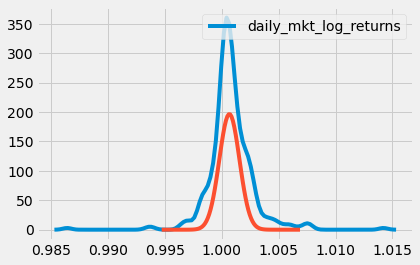

In [95]:
# KDE plots ( kind of too many plots but whatever...)
sns.kdeplot(FIT_daily_returns) # Comp to norm dist/SPY

#sns.kdeplot(SPY_daily_returns)
mu = FIT_daily_returns.mean() # or 1 for illustrational purposes right?
sigma = FIT_daily_returns.std()
x = np.linspace(FIT_daily_returns.min(), FIT_daily_returns.max(), 100)
plt.plot(norm_dist, norm.pdf(x, mu, sigma)) # Once scipy's in the working environment

C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'FIT daily returns distribution')

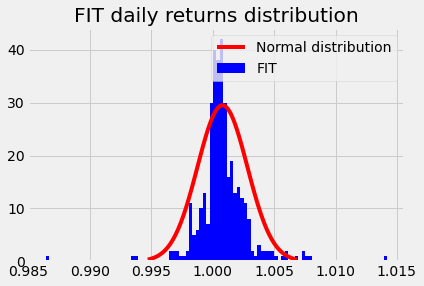

In [100]:
# KDE plots ( kind of too many plots but whatever...)
fig, ax = plt.subplots()
ax.hist(FIT_daily_returns, bins=100, label='FIT', color='b')

mu = FIT_daily_returns.mean() # or 0 for illustrational purposes right?
sigma = FIT_daily_returns.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(norm_dist, 0.15*norm.pdf(x, mu, sigma), label='Normal distribution', color='r')  # CHECK CODE FOR THE NORM DIST AREA.
ax.legend()
ax.set_title('FIT daily returns distribution')

Considering mkt beta dispersion in both markets:

Text(0.5, 1.0, 'Distribution of player stock betas')

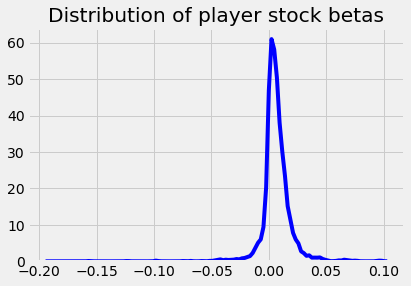

In [103]:
# Gen cov matrix and slice off the useful values
cov = df.groupby(level=1)[['daily_returns', 'daily_mkt_returns']].cov()
cov = cov.loc[(slice(None), 'daily_mkt_returns'), 'daily_returns']

cov.index = cov.index.droplevel(1)
mkt_beta = cov / (df.groupby(level=1)['daily_returns'].std() ** 2)

# PLOT: Market beta dispersion
fig, ax = plt.subplots()
sns.kdeplot(mkt_beta.dropna(), ax=ax, legend=False, color='b')
ax.set_title('Distribution of player stock betas')

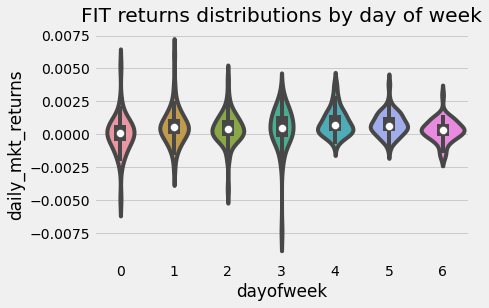

In [105]:
# Consider Business day effects on FI...
df['dayofweek'] = df.index.get_level_values(0)
df['dayofweek'] = df['dayofweek'].dt.weekday

# Extract day of week from index
mkt_returns = df.groupby(level=0)[['daily_mkt_returns', 'dayofweek']].head(1)
mkt_returns.index = mkt_returns.index.droplevel(level=1)

# PLOT: Day of week trends
mkt_returns.groupby('dayofweek').mean()
# PLOT: Market beta dispersion
fig, ax = plt.subplots()
ax.set_title('FIT returns distributions by day of week')
sns.violinplot(x="dayofweek", y='daily_mkt_returns', data=mkt_returns, ax=ax);

What makes the most difference to palyer price (something on feature importance)

# Scouting basic quant strategy (the bit at the end, not mad interesting).

Date
2019-07-01         NaN
2019-07-02    1.000000
2019-07-03    1.000000
2019-07-04    1.000000
2019-07-05    1.000000
                ...   
2020-06-24    0.989146
2020-06-25    0.986414
2020-06-26    0.980949
2020-06-27    0.980949
2020-06-28    0.980949
Name: cumulative_pf_returns, Length: 364, dtype: float64


C:\Users\micha\Documents\Quant\football_index\strategies_and_optimisation.py:70: RuntimeWarning: invalid value encountered in greater_equal
  portfolio_df[portfolio_df.values >= cutoff.values.reshape(len(cutoff),1)] = 1
C:\Users\micha\Documents\Quant\football_index\strategies_and_optimisation.py:71: RuntimeWarning: invalid value encountered in less
  portfolio_df[portfolio_df.values < cutoff.values.reshape(len(cutoff),1)] = 0


Strategy daily Sharpe: 0.4037254076908823


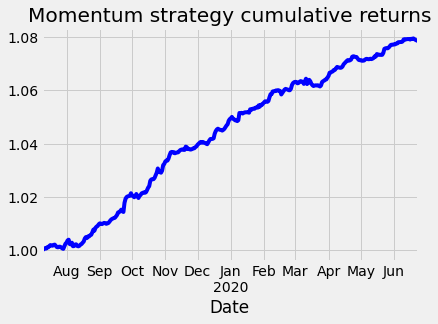

In [106]:
# STRATEGY 1: Price momentum
data = top200
strategy = momentum_strat
param_grid = {'lookback_window': [3, 7, 14, 21],
              'holding_period': [3, 7, 14, 21]}

#results = custom_grid_search(data, strategy, param_grid)
print(results)

optimal_params =  {'holding_period': 7,
                   'lookback_window': 7}
# TODO: Get grid_search returning optimal params to chuck in. (then only run optimals in the final thing.)
results = momentum_strat(data, param_dict=optimal_params)
results.plot(title='Momentum strategy cumulative returns') # TODO: Get params returning sharpe, then vis results

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

Sharpe >< FIT???

In [53]:
# STRATEGY 2: Mean reversion
# Find biggest losers in past x period, and long them. # This is a bad strat but holding periods tell us something???
data = top200
strategy = mean_reversion
param_grid = {'lookback_window': [3, 7, 14, 21],
              'holding_period': [3, 7, 14, 21]}

#results = custom_grid_search(data, strategy, param_grid)
print(results)

optimal_params =  {'holding_period': 7,
                   'lookback_window': 21}

results = mean_reversion(data, param_dict=optimal_params)
results = momentum_strat(data, param_dict=optimal_params)
results.plot(title='Momentum strategy cumulative returns') # TODO: Get params returning sharpe, then vis results

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

Date
2019-07-09         NaN
2019-07-10    0.999876
2019-07-11    1.000721
2019-07-12    1.000660
2019-07-13    1.000607
                ...   
2020-06-19    1.079532
2020-06-20    1.079241
2020-06-21    1.078981
2020-06-22    1.078773
2020-06-23    1.078574
Freq: D, Name: cumulative_pf_returns, Length: 351, dtype: float64


Date
2019-07-01         NaN
2019-07-02    1.000000
2019-07-03    1.000000
2019-07-04    1.000000
2019-07-05    1.000000
                ...   
2020-06-24    1.036051
2020-06-25    1.035954
2020-06-26    1.036136
2020-06-27    1.036385
2020-06-28    1.036492
Name: cumulative_pf_returns, Length: 364, dtype: float64


C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\micha\Documents\Quant\football_index\strategies_and_optimisation.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  technicals_df.loc[technicals_df > 0,:] = 1


Strategy daily Sharpe: 0.19000012292549173


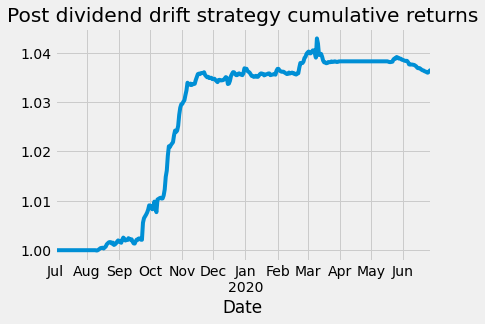

In [108]:
# STRATEGY 3: Post div. drift
data = top200
strategy = post_div_drift
param_grid = {'holding_period': [3, 6, 13, 20]}

#results = custom_grid_search(data, strategy, param_grid)
print(results)

optimal_params =  {'holding_period': 20}

results = post_div_drift(data, param_dict=optimal_params)
results.plot(title='Post dividend drift strategy cumulative returns')

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

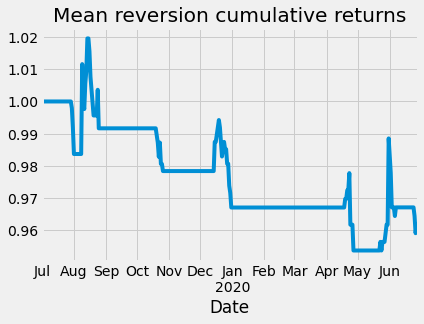

In [54]:
# STRATEGY 4.1: SMAC (single player)
data = top200.loc[(slice(None),'Mohamed Salah'), 'EndofDayPrice'].unstack()
strategy = SMAC
param_grid = {'duration_MA1': [5, 22],
              'duration_MA2': [5, 22]}

#results = custom_grid_search(data, strategy, param_grid)
#print(results)

optimal_params =  {'duration_MA1': 5, 'duration_MA2': 22}

results = SMAC(data, param_dict=optimal_params)
results.plot(title='Mean reversion cumulative returns')


daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

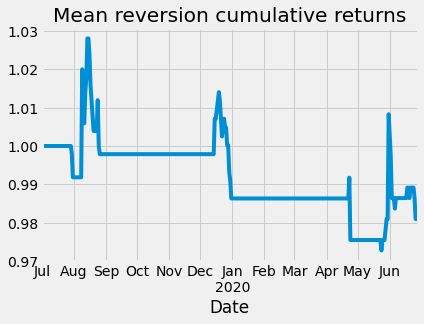

In [55]:
# STRATEGY 4.2: EMAC
data = top200.loc[(slice(None),'Mohamed Salah'), 'EndofDayPrice'].unstack()
strategy = EMAC
param_grid = {'duration_EMA1': [5, 22],
              'duration_EMA2': [5, 22]}

#results = custom_grid_search(data, strategy, param_grid)
#print(results)

optimal_params =  {'duration_EMA1': 5, 'duration_EMA2': 22}

results = EMAC(data, param_dict=optimal_params)
results.plot(title='Mean reversion cumulative returns')


daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

Long only makes the above a problem

Top sharpe is...